In [7]:
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from DLAIUtils import Utils

import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from dotenv import load_dotenv, find_dotenv
import openai
_ = load_dotenv(find_dotenv())

openai.api_key = os.environ["OPENAI_API_KEY"]

In [8]:
!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

'wget' is not recognized as an internal or external command,
operable program or batch file.


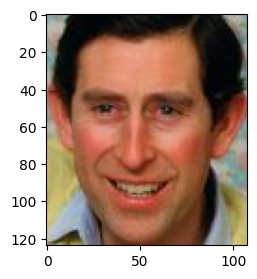

In [10]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('data/family/dad/P06260_face5.jpg')

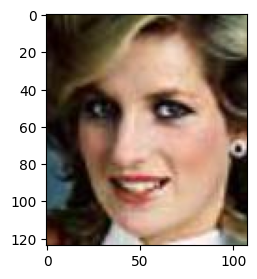

In [12]:
show_img('data/family/mom/P04407_face2.jpg')

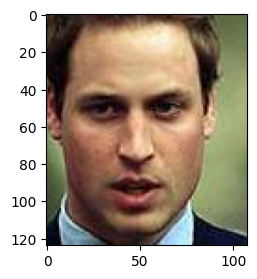

In [13]:
show_img('data/family/child/P04414_face1.jpg')


In [14]:
MODEL = "Facenet"
INDEX_NAME = INDEX_NAME = f'dl-ai-{openai.api_key[-36:].lower().replace("_", "-")}'

pinecone = Pinecone(api_key=os.environ['PINECONE_API_KEY'])

In [17]:
def generate_vectors():
    VECTOR_FILE = "./vectors.vec"

    with contextlib.suppress(FileNotFoundError):
        os.remove(VECTOR_FILE)
    with open(VECTOR_FILE, "w") as f:
        for person in ["mom", "dad", "child"]:
            files = glob.glob(f"data/family/{person}/*")
            for file in tqdm(files):
                try:
                    embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
                    f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
                except (ValueError, UnboundLocalError, AttributeError) as e:
                    print(e)

generate_vectors()

  0%|          | 0/78 [00:00<?, ?it/s]

24-02-09 18:09:08 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: C:\Users\User\.deepface\weights\facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:02<00:00, 40.2MB/s]
100%|██████████| 93/93 [00:15<00:00,  6.09it/s]


In [18]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 11472.07it/s]


transform 70 vectors


241it [00:00, 8310.47it/s]


transform 93 vectors


241it [00:00, 8309.79it/s]

transform 78 vectors


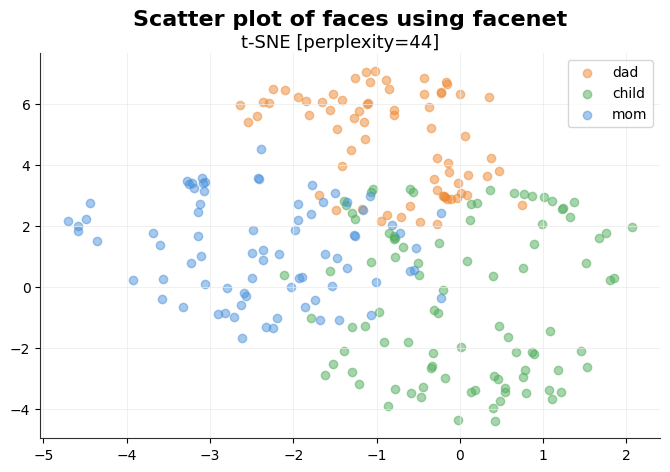

In [25]:
plot_tsne(44, 'facenet')

In [26]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=128, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-west-2'))

index = pinecone.Index(INDEX_NAME)

In [27]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [00:56,  4.27it/s]


In [28]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241}

In [29]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [31]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 3595.18it/s]


DAD --------------------


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]




dad AVG: 0.41020249636999995
MOM --------------------


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]



mom AVG: 0.34941427901
